<a href="https://colab.research.google.com/github/jakubLabendowicz/ssi_projekt/blob/main/Projekt_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flask --quiet
!pip install flask-ngrok --quiet
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
!tar -xvf /content/ngrok-stable-linux-amd64.tgz
!./ngrok authtoken 2QDA5F0iydHs5KsiCwy3lPcdpUg_3g6x4CKLj77XscthrEVA4
!pip install flask-bootstrap

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from datetime import date
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from keras.layers import GRU, Input
from keras.models import Model
import os.path
from os import path
from flask import Flask, render_template
from flask_bootstrap import Bootstrap
from flask_ngrok import run_with_ngrok

--2023-05-24 06:42:40--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13856790 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.tgz’

ngrok-stable-linux- 100%[===================>]  13.21M  39.0MB/s    in 0.3s    

2023-05-24 06:42:40 (39.0 MB/s) - ‘ngrok-stable-linux-amd64.tgz’ saved [13856790/13856790]

ngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.4/456.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for flask-bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size

In [24]:
if path.exists('./templates') == False:
  os.mkdir('./templates')

if path.exists('./static') == False:
  os.mkdir('./static')

if path.exists('./static/CSS') == False:
  os.mkdir('./static/CSS')

if path.exists('./static/fonts') == False:
  os.mkdir('./static/fonts')

if path.exists('./static/images') == False:
  os.mkdir('./static/images')

if path.exists('./static/js') == False:
  os.mkdir('./static/js')

In [3]:
def updateData():
  oil = yf.download("AAPL", start= date.today() - relativedelta(months = 3), end=date.today())

  if path.exists('./data') == False:
    os.mkdir('./data')

  try:
      existing_data = pd.read_csv('./data/data.csv')
      oil = pd.concat([existing_data, oil])
  except FileNotFoundError:
      pass

  oil.to_csv('./data/data.csv', index=False)

updateData()

[*********************100%***********************]  1 of 1 completed


In [20]:
def normalizeData(data):
  scaler = MinMaxScaler(feature_range=(0, 1))
  data = scaler.fit_transform(data.reshape(-1, 1))
  return (data, scaler)

In [5]:
def splitData(data):
  train_size = int(len(data) * 0.67)
  test_size = len(data) - train_size
  train_data, test_data = data[0:train_size], data[train_size:len(data)]
  return (train_data, test_data)

In [6]:
def prepareData(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

In [7]:
def reshapeData(data):
  data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
  return data

In [17]:
def createLstmModel(look_back):
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [18]:
def createGruModel(look_back):
  model = Sequential()
  model.add(GRU(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [10]:
def createMseShape(model_name, value_name, test_Y, predicted_Value):
  mse = mean_squared_error(test_Y[0], predicted_Value[:, 0])
  print('MSE:', mse)

  shape = plt.figure(figsize=(10, 6))
  plt.bar(range(1), mse)
  plt.xlabel(mse)
  plt.ylabel('MSE')
  plt.title('Mse [' + value_name + ']')
  plt.legend()
  plt.savefig('./static/images/'+ model_name + '_' + value_name + '_' + 'mse_shape.png')
  shape.show()
  return shape

In [11]:
def createComparisonShape(model_name, value_name, test_Y, predicted_Value):
  shape = plt.figure(figsize=(10, 6))
  plt.plot(test_Y[0], label='Rzeczywiste [' + value_name + ']')
  plt.plot(predicted_Value[:, 0], label='Przewidziane [' + value_name + ']')
  plt.xlabel('Indeks czasu')
  plt.ylabel(value_name)
  plt.title('Porównanie rzeczywistych i przewidzianych [' + value_name + ']')
  plt.legend()
  plt.savefig('./static/images/'+ model_name + '_' + value_name + '_' + 'comparison_shape.png')
  shape.show()
  return shape

In [12]:
def createDeviationShape(model_name, value_name, test_Y, predicted_Value):
  deviation = predicted_Value[:, 0] - test_Y[0]
  shape = plt.figure(figsize=(10, 6))
  plt.bar(range(len(deviation)), deviation)
  plt.xlabel('Indeks czasu')
  plt.ylabel('Odchylenie')
  plt.title('Odchylenie od rzeczywistej wartości [' + value_name + ']')
  plt.legend()
  plt.savefig('./static/images/'+ model_name + '_' + value_name + '_' + 'deviation_shape.png')
  plt.show()
  return shape

Epoch 1/100
39/39 - 2s - loss: 0.2073 - 2s/epoch - 40ms/step
Epoch 2/100
39/39 - 0s - loss: 0.1713 - 49ms/epoch - 1ms/step
Epoch 3/100
39/39 - 0s - loss: 0.1382 - 53ms/epoch - 1ms/step
Epoch 4/100
39/39 - 0s - loss: 0.1083 - 56ms/epoch - 1ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0830 - 53ms/epoch - 1ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0619 - 53ms/epoch - 1ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0481 - 48ms/epoch - 1ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0390 - 50ms/epoch - 1ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0337 - 45ms/epoch - 1ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0304 - 56ms/epoch - 1ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0290 - 45ms/epoch - 1ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0275 - 64ms/epoch - 2ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0266 - 55ms/epoch - 1ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0255 - 53ms/epoch - 1ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0247 - 57ms/epoch - 1ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0239 - 46ms/epoch - 1ms/step
Ep

MSE: 5.897759941247243


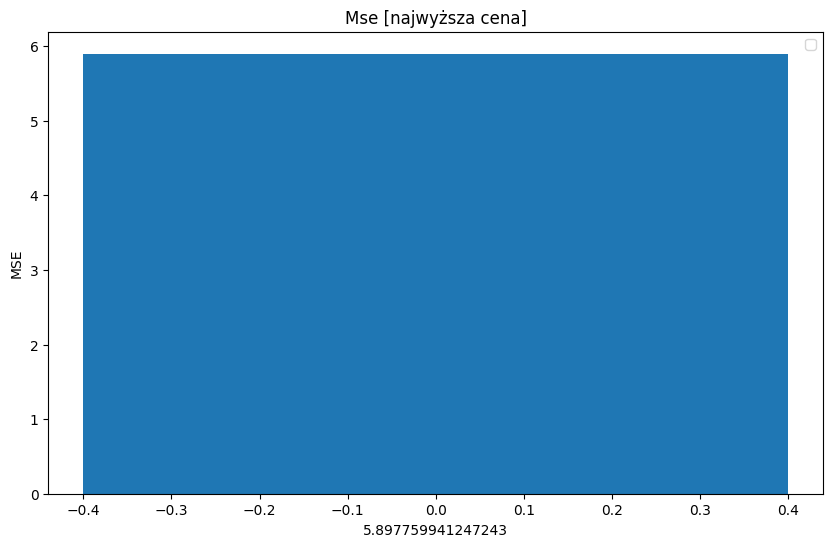

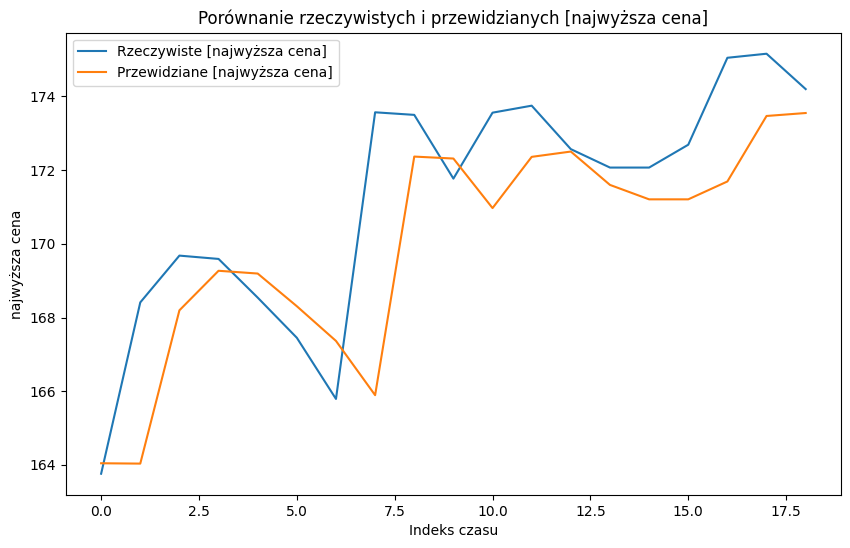

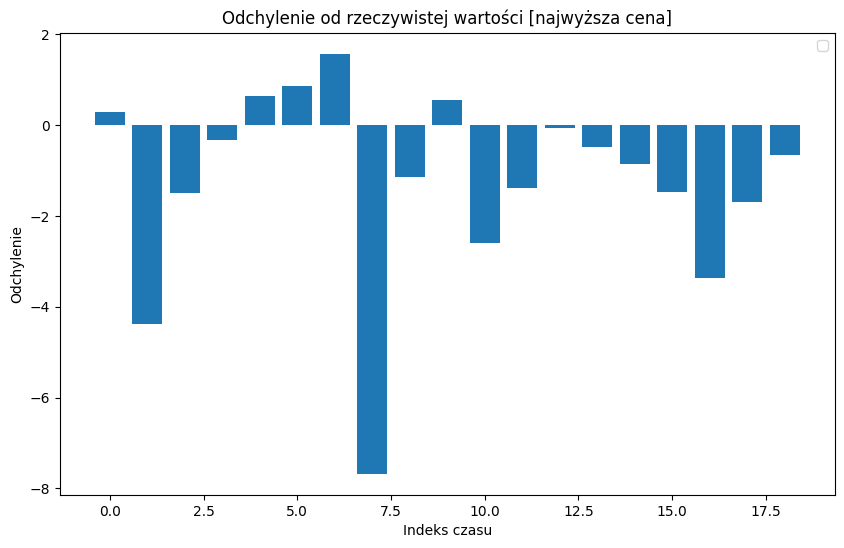

Epoch 1/100
39/39 - 1s - loss: 0.1748 - 1s/epoch - 33ms/step
Epoch 2/100
39/39 - 0s - loss: 0.1041 - 64ms/epoch - 2ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0629 - 54ms/epoch - 1ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0390 - 52ms/epoch - 1ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0300 - 54ms/epoch - 1ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0261 - 54ms/epoch - 1ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0246 - 51ms/epoch - 1ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0232 - 49ms/epoch - 1ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0222 - 54ms/epoch - 1ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0208 - 60ms/epoch - 2ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0201 - 55ms/epoch - 1ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0187 - 56ms/epoch - 1ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0179 - 55ms/epoch - 1ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0169 - 55ms/epoch - 1ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0160 - 68ms/epoch - 2ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0149 - 63ms/epoch - 2ms/step
Ep

MSE: 7.333959981051617


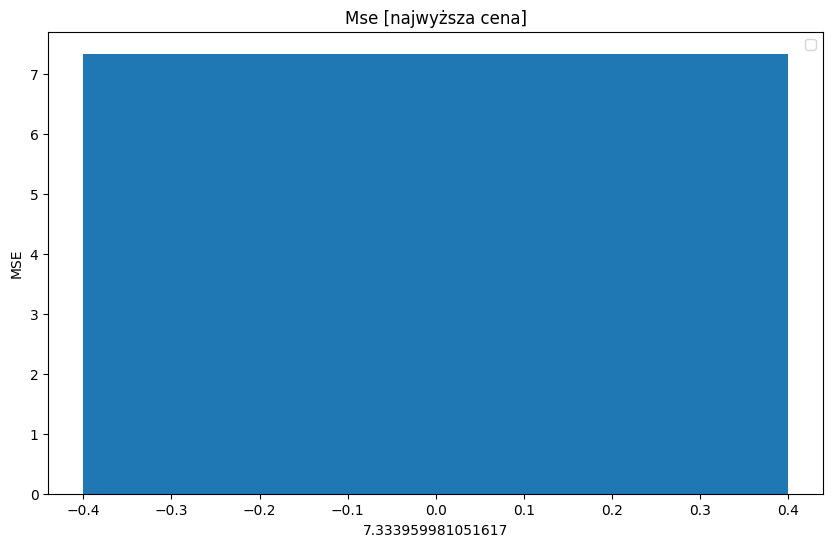

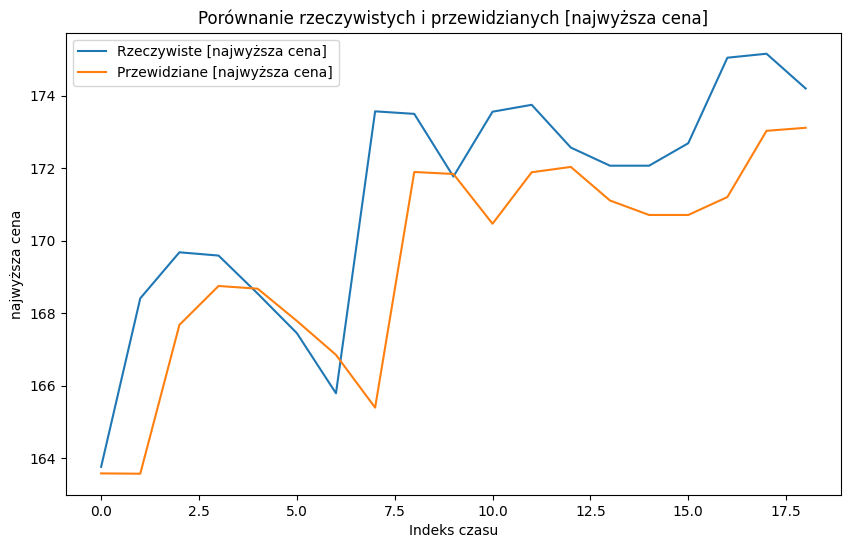

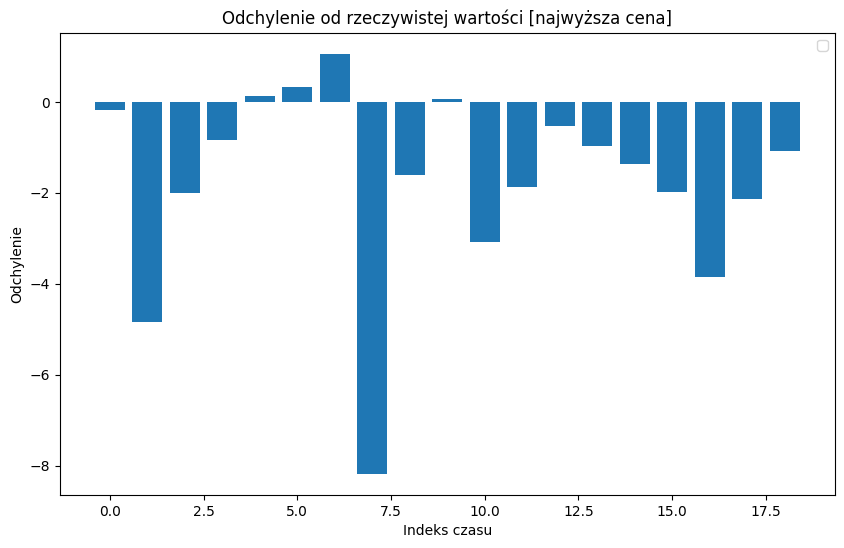

Epoch 1/100
39/39 - 1s - loss: 0.2467 - 1s/epoch - 34ms/step
Epoch 2/100
39/39 - 0s - loss: 0.1915 - 52ms/epoch - 1ms/step
Epoch 3/100
39/39 - 0s - loss: 0.1474 - 53ms/epoch - 1ms/step
Epoch 4/100
39/39 - 0s - loss: 0.1117 - 51ms/epoch - 1ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0846 - 52ms/epoch - 1ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0643 - 56ms/epoch - 1ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0511 - 49ms/epoch - 1ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0416 - 50ms/epoch - 1ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0365 - 52ms/epoch - 1ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0327 - 57ms/epoch - 1ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0307 - 53ms/epoch - 1ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0294 - 60ms/epoch - 2ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0283 - 54ms/epoch - 1ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0272 - 54ms/epoch - 1ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0264 - 57ms/epoch - 1ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0255 - 63ms/epoch - 2ms/step
Ep

MSE: 5.751053665776884


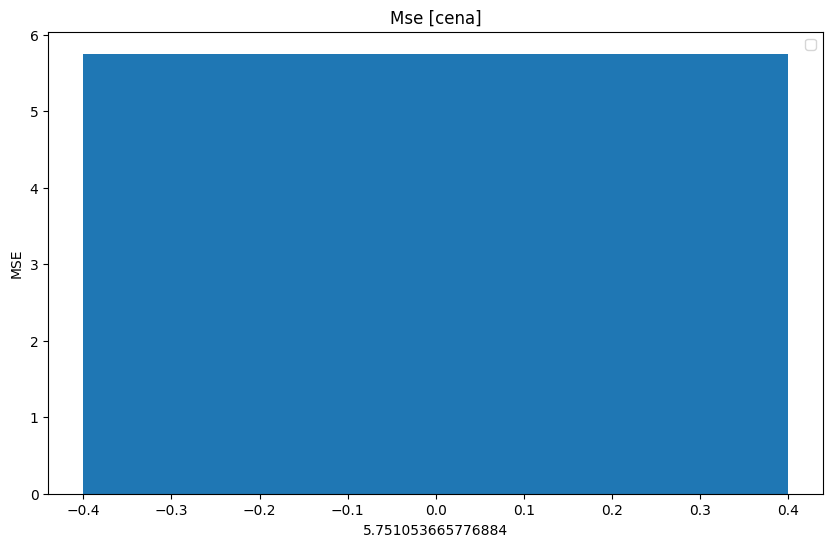

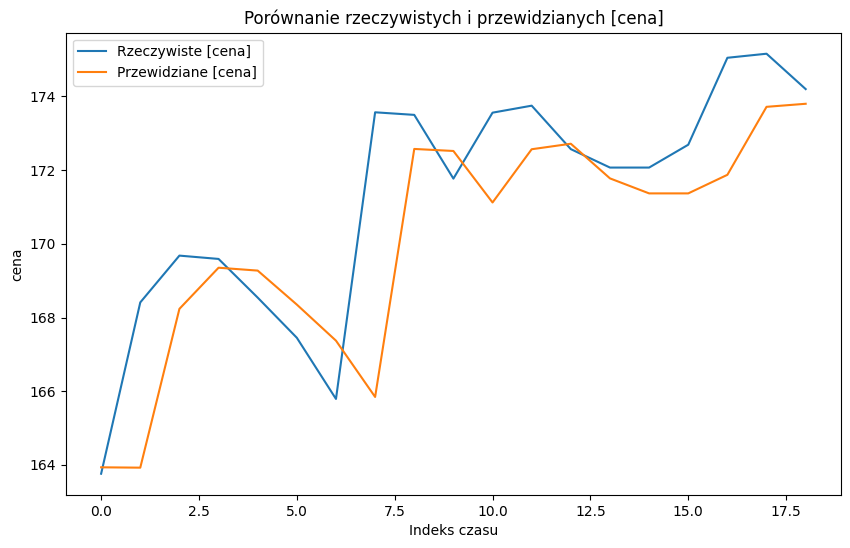

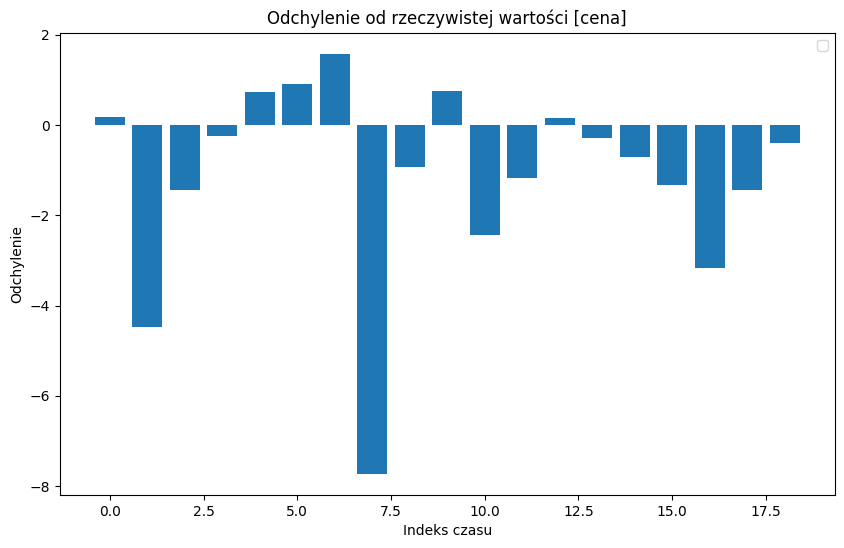

Epoch 1/100
39/39 - 1s - loss: 0.1459 - 1s/epoch - 32ms/step
Epoch 2/100
39/39 - 0s - loss: 0.0697 - 52ms/epoch - 1ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0375 - 51ms/epoch - 1ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0278 - 45ms/epoch - 1ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0254 - 48ms/epoch - 1ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0239 - 50ms/epoch - 1ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0222 - 55ms/epoch - 1ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0210 - 55ms/epoch - 1ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0195 - 50ms/epoch - 1ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0179 - 49ms/epoch - 1ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0166 - 56ms/epoch - 1ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0154 - 60ms/epoch - 2ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0142 - 56ms/epoch - 1ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0131 - 50ms/epoch - 1ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0121 - 53ms/epoch - 1ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0111 - 54ms/epoch - 1ms/step
Ep

1/1 [==============================] - 0s 267ms/step


MSE: 5.308140566315208


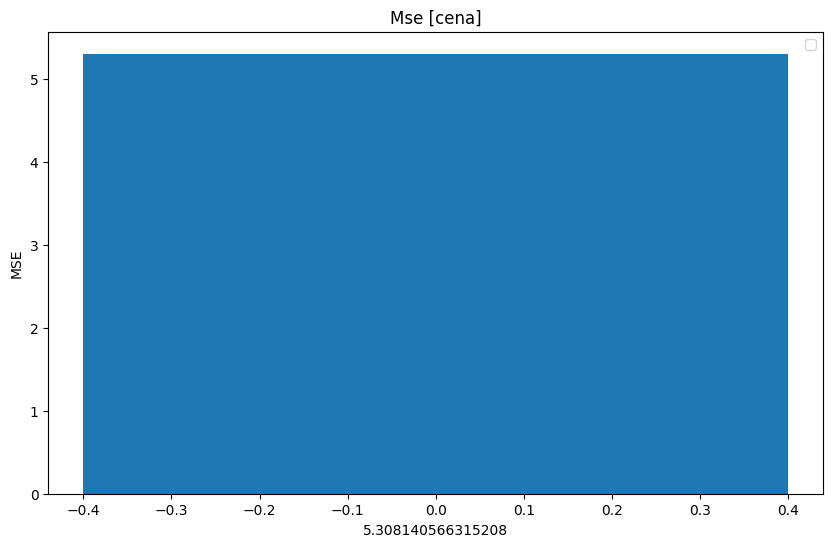

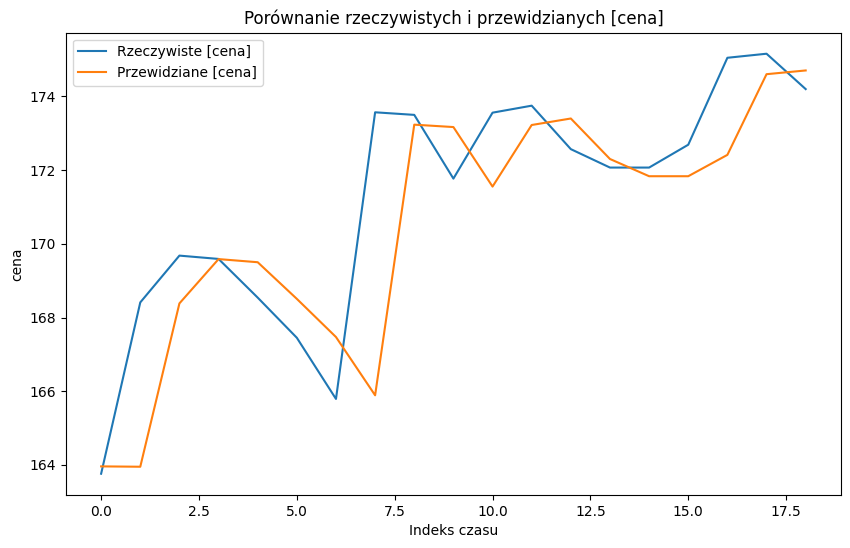

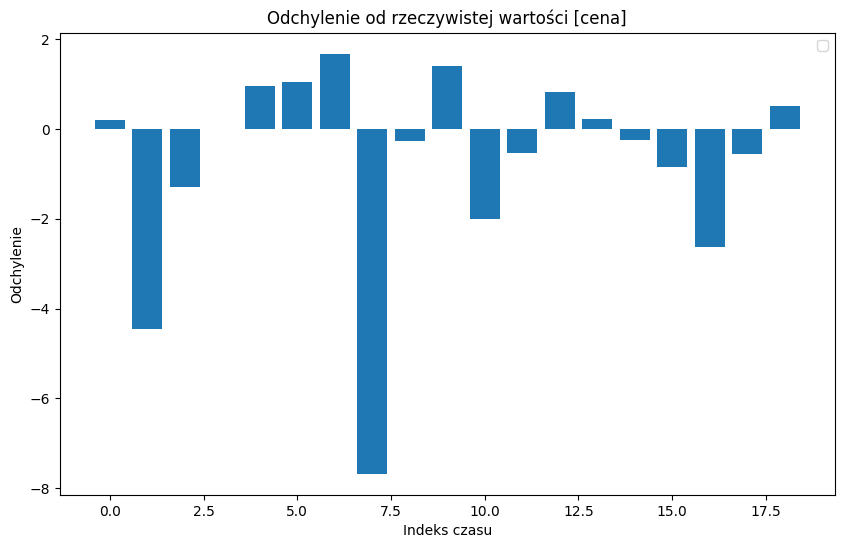

Epoch 1/100
39/39 - 1s - loss: 0.1084 - 1s/epoch - 37ms/step
Epoch 2/100
39/39 - 0s - loss: 0.0849 - 80ms/epoch - 2ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0659 - 78ms/epoch - 2ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0515 - 82ms/epoch - 2ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0416 - 67ms/epoch - 2ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0352 - 63ms/epoch - 2ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0318 - 60ms/epoch - 2ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0297 - 64ms/epoch - 2ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0288 - 68ms/epoch - 2ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0282 - 71ms/epoch - 2ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0279 - 59ms/epoch - 2ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0276 - 58ms/epoch - 1ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0274 - 65ms/epoch - 2ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0272 - 66ms/epoch - 2ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0268 - 66ms/epoch - 2ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0266 - 59ms/epoch - 2ms/step
Ep

1/1 [==============================] - 0s 301ms/step


MSE: 241856267804435.38


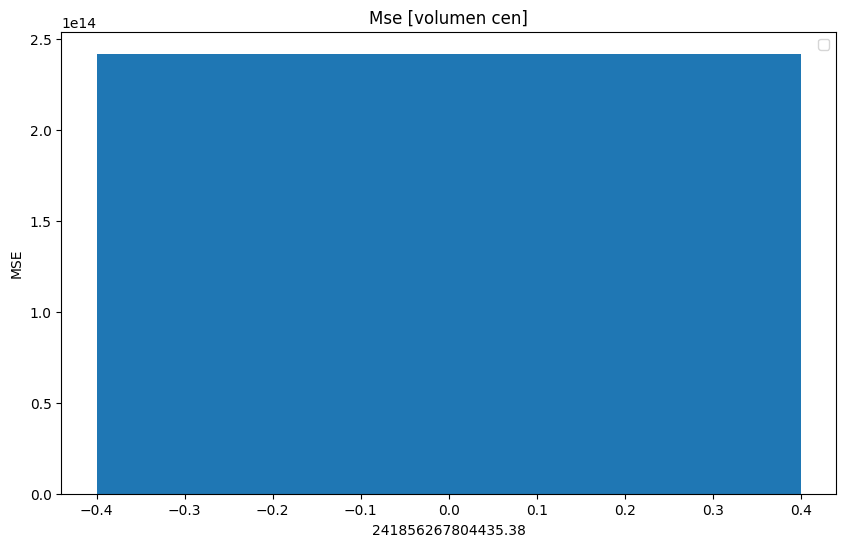

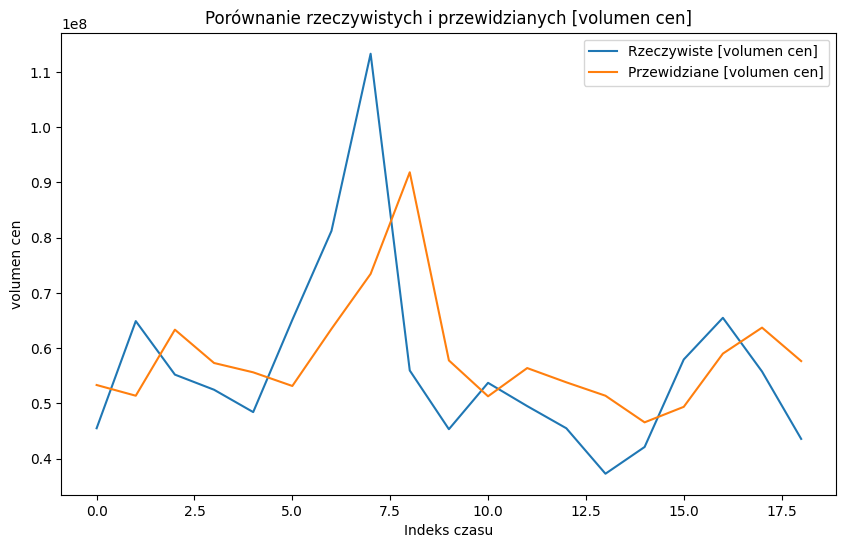

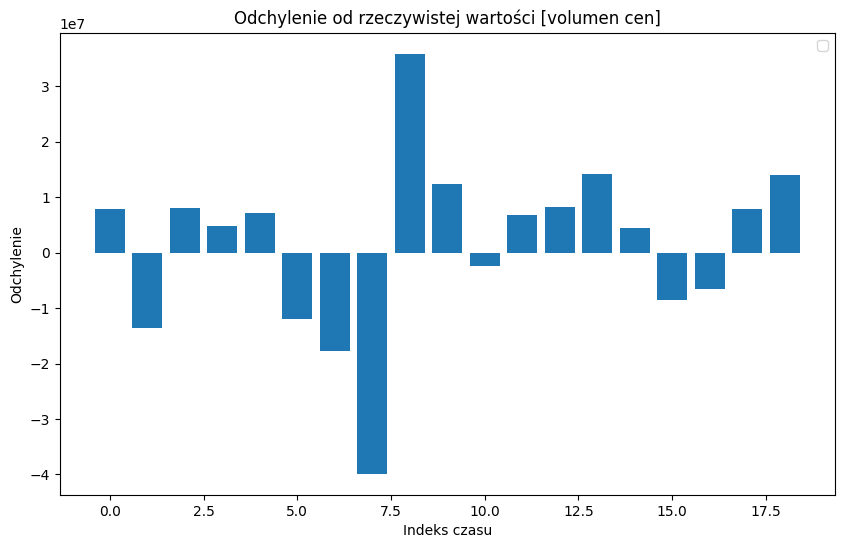

Epoch 1/100
39/39 - 2s - loss: 0.0849 - 2s/epoch - 52ms/step
Epoch 2/100
39/39 - 0s - loss: 0.0558 - 69ms/epoch - 2ms/step
Epoch 3/100
39/39 - 0s - loss: 0.0394 - 76ms/epoch - 2ms/step
Epoch 4/100
39/39 - 0s - loss: 0.0310 - 58ms/epoch - 1ms/step
Epoch 5/100
39/39 - 0s - loss: 0.0275 - 63ms/epoch - 2ms/step
Epoch 6/100
39/39 - 0s - loss: 0.0265 - 58ms/epoch - 1ms/step
Epoch 7/100
39/39 - 0s - loss: 0.0260 - 60ms/epoch - 2ms/step
Epoch 8/100
39/39 - 0s - loss: 0.0257 - 58ms/epoch - 1ms/step
Epoch 9/100
39/39 - 0s - loss: 0.0254 - 52ms/epoch - 1ms/step
Epoch 10/100
39/39 - 0s - loss: 0.0254 - 53ms/epoch - 1ms/step
Epoch 11/100
39/39 - 0s - loss: 0.0251 - 68ms/epoch - 2ms/step
Epoch 12/100
39/39 - 0s - loss: 0.0246 - 53ms/epoch - 1ms/step
Epoch 13/100
39/39 - 0s - loss: 0.0245 - 61ms/epoch - 2ms/step
Epoch 14/100
39/39 - 0s - loss: 0.0246 - 56ms/epoch - 1ms/step
Epoch 15/100
39/39 - 0s - loss: 0.0242 - 63ms/epoch - 2ms/step
Epoch 16/100
39/39 - 0s - loss: 0.0240 - 61ms/epoch - 2ms/step
Ep

MSE: 240576628618363.78


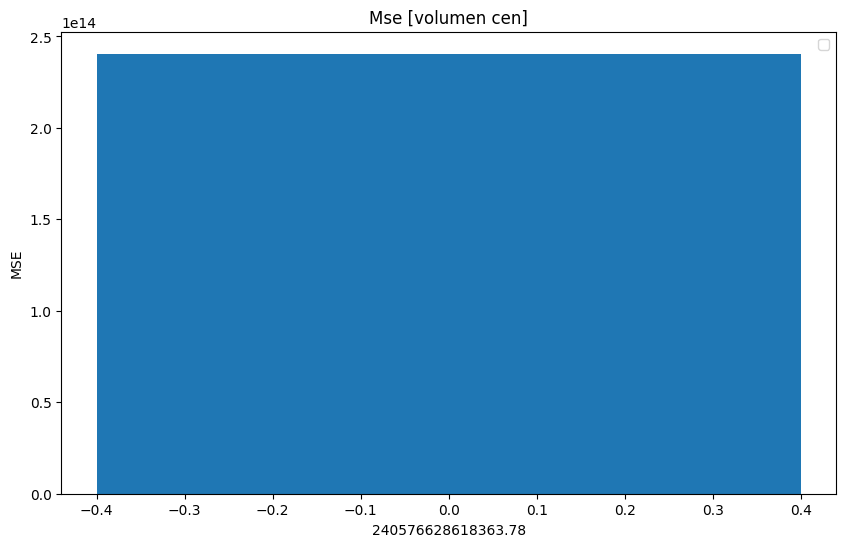

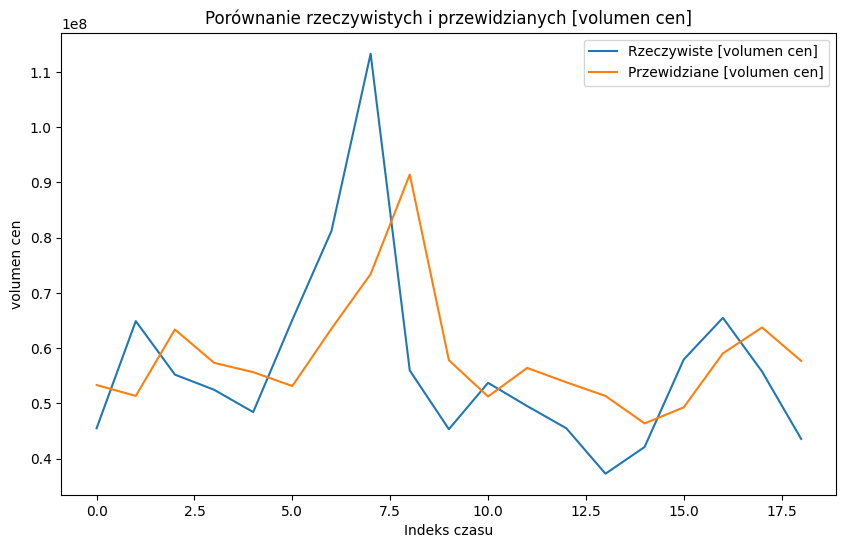

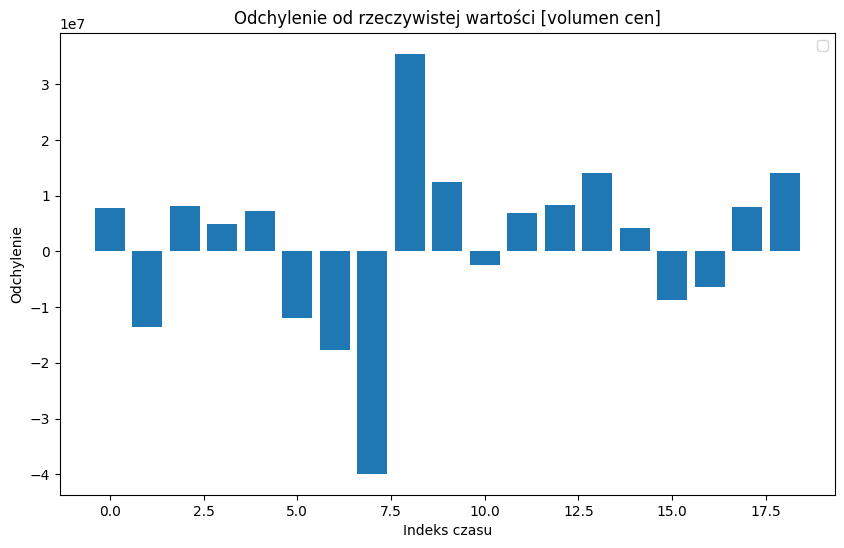

In [21]:
def process():
  look_back = 1
  data = pd.read_csv('./data/data.csv')

  # High price
  high_price = data['Close'].values
  high_price, scaler = normalizeData(high_price)
  high_price_train_data, high_price_test_data = splitData(high_price)
  high_price_train_X, high_price_train_Y = prepareData(high_price_train_data, look_back)
  high_price_test_X, high_price_test_Y = prepareData(high_price_test_data, look_back)

  lstm_high_price_train_X = reshapeData(high_price_train_X)
  lstm_high_price_test_X = reshapeData(high_price_test_X)
  lstm_high_price_model = createLstmModel(look_back)
  lstm_high_price_model.fit(lstm_high_price_train_X, high_price_train_Y, epochs=100, batch_size=1, verbose=2)
  lstm_predicted_high_price = lstm_high_price_model.predict(lstm_high_price_test_X)
  lstm_predicted_high_price = scaler.inverse_transform(lstm_predicted_high_price)
  lstm_high_price_test_Y = scaler.inverse_transform([high_price_test_Y])
  lstm_high_price_mse_shape = createMseShape('lstm', 'najwyższa cena', lstm_high_price_test_Y, lstm_predicted_high_price)
  lstm_high_price_comparison_shape = createComparisonShape('lstm', 'najwyższa cena', lstm_high_price_test_Y, lstm_predicted_high_price)
  lstm_high_price_deviation_shape = createDeviationShape('lstm', 'najwyższa cena', lstm_high_price_test_Y, lstm_predicted_high_price)

  gru_high_price_train_X = reshapeData(high_price_train_X)
  gru_high_price_test_X = reshapeData(high_price_test_X)
  gru_high_price_model = createGruModel(look_back)
  gru_high_price_model.fit(gru_high_price_train_X, high_price_train_Y, epochs=100, batch_size=1, verbose=2)
  gru_predicted_high_price = gru_high_price_model.predict(gru_high_price_test_X)
  gru_predicted_high_price = scaler.inverse_transform(gru_predicted_high_price)
  gru_high_price_test_Y = scaler.inverse_transform([high_price_test_Y])
  gru_high_price_mse_shape = createMseShape('gru', 'najwyższa cena', gru_high_price_test_Y, gru_predicted_high_price)
  gru_high_price_comparison_shape = createComparisonShape('gru', 'najwyższa cena', gru_high_price_test_Y, gru_predicted_high_price)
  gru_high_price_deviation_shape = createDeviationShape('gru', 'najwyższa cena', gru_high_price_test_Y, gru_predicted_high_price)

  # Close price
  price = data['Close'].values
  price, scaler = normalizeData(price)
  price_train_data, price_test_data = splitData(price)
  price_train_X, price_train_Y = prepareData(price_train_data, look_back)
  price_test_X, price_test_Y = prepareData(price_test_data, look_back)

  lstm_price_train_X = reshapeData(price_train_X)
  lstm_price_test_X = reshapeData(price_test_X)
  lstm_price_model = createLstmModel(look_back)
  lstm_price_model.fit(lstm_price_train_X, price_train_Y, epochs=100, batch_size=1, verbose=2)
  lstm_predicted_price = lstm_price_model.predict(lstm_price_test_X)
  lstm_predicted_price = scaler.inverse_transform(lstm_predicted_price)
  lstm_price_test_Y = scaler.inverse_transform([price_test_Y])
  lstm_price_mse_shape = createMseShape('lstm', 'cena', lstm_price_test_Y, lstm_predicted_price)
  lstm_price_comparison_shape = createComparisonShape('lstm', 'cena', lstm_price_test_Y, lstm_predicted_price)
  lstm_price_deviation_shape = createDeviationShape('lstm', 'cena', lstm_price_test_Y, lstm_predicted_price)

  gru_price_train_X = reshapeData(price_train_X)
  gru_price_test_X = reshapeData(price_test_X)
  gru_price_model = createGruModel(look_back)
  gru_price_model.fit(gru_price_train_X, price_train_Y, epochs=100, batch_size=1, verbose=2)
  gru_predicted_price = gru_price_model.predict(gru_price_test_X)
  gru_predicted_price = scaler.inverse_transform(gru_predicted_price)
  gru_price_test_Y = scaler.inverse_transform([price_test_Y])
  gru_price_mse_shape = createMseShape('gru', 'cena', gru_price_test_Y, gru_predicted_price)
  gru_price_comparison_shape = createComparisonShape('gru', 'cena', gru_price_test_Y, gru_predicted_price)
  gru_price_deviation_shape = createDeviationShape('gru', 'cena', gru_price_test_Y, gru_predicted_price)

  # Volume
  volume = data['Volume'].values
  volume, scaler = normalizeData(volume)
  volume_train_data, volume_test_data = splitData(volume)
  volume_train_X, volume_train_Y = prepareData(volume_train_data, look_back)
  volume_test_X, volume_test_Y = prepareData(volume_test_data, look_back)

  lstm_volume_train_X = reshapeData(volume_train_X)
  lstm_volume_test_X = reshapeData(volume_test_X)
  lstm_volume_model = createLstmModel(look_back)
  lstm_volume_model.fit(volume_train_X, volume_train_Y, epochs=100, batch_size=1, verbose=2)
  lstm_predicted_volume = lstm_volume_model.predict(lstm_volume_test_X)
  lstm_predicted_volume = scaler.inverse_transform(lstm_predicted_volume)
  lstm_volume_test_Y = scaler.inverse_transform([volume_test_Y])
  lstm_volume_mse_shape = createMseShape('lstm', 'volumen cen', lstm_volume_test_Y, lstm_predicted_volume)
  lstm_volume_comparison_shape = createComparisonShape('lstm', 'volumen cen', lstm_volume_test_Y, lstm_predicted_volume)
  lstm_volume_deviation_shape = createDeviationShape('lstm', 'volumen cen', lstm_volume_test_Y, lstm_predicted_volume)

  gru_volume_train_X = reshapeData(volume_train_X)
  gru_volume_test_X = reshapeData(volume_test_X)
  gru_volume_model = createGruModel(look_back)
  gru_volume_model.fit(volume_train_X, volume_train_Y, epochs=100, batch_size=1, verbose=2)
  gru_predicted_volume = gru_volume_model.predict(gru_volume_test_X)
  gru_predicted_volume = scaler.inverse_transform(gru_predicted_volume)
  gru_volume_test_Y = scaler.inverse_transform([volume_test_Y])
  gru_volume_mse_shape = createMseShape('gru', 'volumen cen', gru_volume_test_Y, gru_predicted_volume)
  gru_volume_comparison_shape = createComparisonShape('gru', 'volumen cen', gru_volume_test_Y, gru_predicted_volume)
  gru_volume_deviation_shape = createDeviationShape('gru', 'volumen cen', gru_volume_test_Y, gru_predicted_volume)

process()

In [ ]:
app = Flask(__name__)
app.static_folder = '/content/static'
bootstrap = Bootstrap(app)
run_with_ngrok(app)

@app.route("/")
def home():
  return render_template("index.html")

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://b5ee-162-222-181-198.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:27] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:27] "GET /static/images/lstm_najwyższa%20cena_deviation_shape.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:27] "GET /static/images/lstm_cena_mse_shape.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:27] "GET /static/images/lstm_cena_deviation_shape.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:27] "GET /static/images/lstm_najwyższa%20cena_mse_shape.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:28] "GET /static/images/gru_najwyższa%20cena_comparison_shape.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:28] "GET /static/images/lstm_cena_comparison_shape.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:28] "GET /static/images/gru_najwyższa%20cena_mse_shape.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/May/2023 07:41:28] "GET /static/images/gru_ce